In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
import os
from transformers import DataCollatorForSeq2Seq
import random

2025-05-14 06:30:28.202564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 06:30:28.202640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 06:30:28.203630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 06:30:28.209463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-14 06:30:29.085395: W tensorflow/compiler/tf2

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"
import torch

In [3]:
from transformers import AutoTokenizer, T5Config, T5ForConditionalGeneration

# Tokenizer is still needed and must be pre-defined (uses bytes, not learnable from scratch)
tokenizer = AutoTokenizer.from_pretrained("google/byt5-small")  # Still uses Byte-level tokenizer

# Create a fresh, randomly initialized model
config = T5Config.from_pretrained("google/byt5-small")  # Same architecture
model = T5ForConditionalGeneration(config)  # Fresh weights

In [3]:

with open('words_250000_train.txt', 'r') as f:
    words = f.read().splitlines()
data = np.random.permutation(words)


In [4]:
# data=data[:500]
split_index= int(0.95 * len(data))

# random.shuffle(data)
train_words = data[:split_index]
val_words = data[split_index:]

In [5]:
BYT5_MASK_TOKEN = "<mask>"
BYT5_SEP_TOKEN = "<sep>"

In [6]:
def simulate_game(word, correct_rate=0.4, max_wrong_guesses=6):
    word_idxs = {}
    all_letters = [chr(i) for i in range(ord('a'), ord('z') + 1)]
    for i, c in enumerate(word):
        if c not in word_idxs:
            word_idxs[c] = []
        word_idxs[c].append(i)
    guesses = {}
    encoded_word = "*" * len(word)
    num_guesses = 0
    states, outputs = [], []
    while encoded_word != word and num_guesses < max_wrong_guesses:
        output = np.zeros(26)
        for ch in word_idxs:
            if ch not in guesses:
                output[ord(ch) - ord('a')] = len(word_idxs[ch])
        out_sum = np.sum(output)
        if out_sum > 0:
            output = output / out_sum
        else:
            raise ValueError("Invalid output distribution")
        outputs.append(output)
        states.append(''.join(guesses.keys()) + BYT5_SEP_TOKEN + encoded_word.replace('*', BYT5_MASK_TOKEN))
        correct_guess = np.random.random() < correct_rate
        if correct_guess:
            guess = np.random.choice(list(word_idxs.keys()))
            while guess in guesses:
                guess = np.random.choice(list(word_idxs.keys()))
        else:
            guess = np.random.choice(all_letters)
            while guess in guesses:
                guess = np.random.choice(all_letters)
        if guess in word_idxs:
            for i in word_idxs[guess]:
                encoded_word = encoded_word[:i] + guess + encoded_word[i + 1:]
        else:
            num_guesses += 1
        guesses[guess] = True
    return states, np.array(outputs), int(encoded_word == word)

def encode_game_states(word_list):
    all_states, all_outputs = [], []
    for word in word_list:
        states, outputs, _ = simulate_game(word)
        all_states.extend(states)
        all_outputs.extend(outputs)
    return all_states, np.array(all_outputs), None

In [8]:
from transformers import AutoTokenizer, T5Config, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
import torch

# Load tokenizer and model config
# tokenizer = AutoTokenizer.from_pretrained("google/byt5-small")
# config = T5Config.from_pretrained("google/byt5-small")
# model = T5ForConditionalGeneration(config)

In [43]:
sample = train_dataset[0]
print(sample["input_ids"].dtype)  # should be torch.int64


torch.int64


In [50]:
sample = train_dataset[0]
print(sample["input_ids"].dtype)         # should be torch.int64 (aka “long”)
print(sample["attention_mask"].dtype)    # torch.int64
print(sample["labels"].dtype)            # torch.int64


torch.int64
torch.int64
torch.int64


--------------------




--------------------

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Model Loaded


Map:   0%|          | 0/120851 [00:00<?, ? examples/s]


===== Epoch 1/1 =====


Map:   0%|          | 0/2289945 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.131500,0.130647


Gameplay accuracy after epoch 1: 0.0000
Training complete. Validation curve saved to byt5_val_accuracy.png


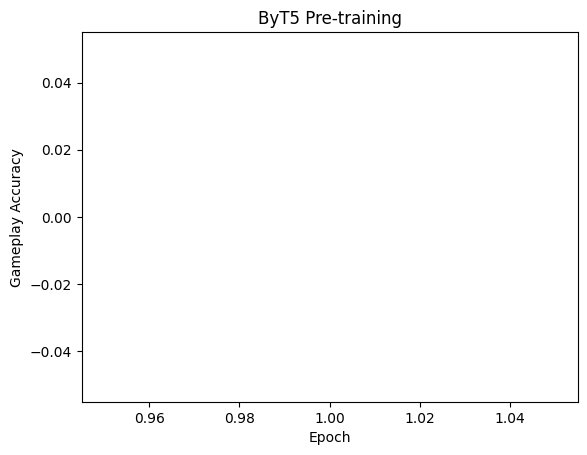

In [7]:
import numpy as np
import torch
from transformers import (
    ByT5Tokenizer,
    T5Config,
    T5ForSequenceClassification,
    TrainingArguments,
    Trainer,
    EvalPrediction
)
from datasets import Dataset
from sklearn.metrics import f1_score, accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm

# Tokenizer and constants for ByT5
BYT5_MASK_TOKEN = "<extra_id_0>"
BYT5_SEP_TOKEN = "<sep>"

def simulate_game(word, correct_rate=0.4, max_wrong_guesses=6):
    word_idxs = {}
    all_letters = [chr(i) for i in range(ord('a'), ord('z') + 1)]
    for i, c in enumerate(word):
        word_idxs.setdefault(c, []).append(i)
    guesses = {}
    encoded_word = "*" * len(word)
    num_guesses = 0
    states, outputs = [], []
    while encoded_word != word and num_guesses < max_wrong_guesses:
        # Build soft‐label distribution over next letter
        output = np.zeros(26)
        for ch, idxs in word_idxs.items():
            if ch not in guesses:
                output[ord(ch) - ord('a')] = len(idxs)
        out_sum = output.sum()
        if out_sum > 0:
            output = output / out_sum
        outputs.append(output)

        # Encode state: guessed letters + masked word
        state = ''.join(guesses.keys()) + BYT5_SEP_TOKEN + encoded_word.replace('*', BYT5_MASK_TOKEN)
        states.append(state)

        # Decide guess (correct vs random)
        if np.random.rand() < correct_rate:
            guess = np.random.choice([c for c in word_idxs if c not in guesses])
        else:
            guess = np.random.choice([c for c in all_letters if c not in guesses])

        # Apply guess
        if guess in word_idxs:
            for i in word_idxs[guess]:
                encoded_word = encoded_word[:i] + guess + encoded_word[i+1:]
        else:
            num_guesses += 1
        guesses[guess] = True

    return states, np.array(outputs), int(encoded_word == word)

def encode_game_states(dictionary):
    all_states, all_outputs = [], []
    total_solved = 0
    for w in dictionary:
        states, outputs, solved = simulate_game(w)
        all_states.extend(states)
        all_outputs.extend(outputs)
        total_solved += solved
    return all_states, np.array(all_outputs), total_solved / len(dictionary)

def metrics(preds, labels):
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(labels, axis=1)
    return {
        "f1": f1_score(y_true, y_pred, average="macro"),
        "accuracy": accuracy_score(y_true, y_pred)
    }

def compute_metrics(p: EvalPrediction):
    logits = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    return metrics(logits, p.label_ids)

class ByT5HangmanPlayer:
    """
    Hangman Player using Google ByT5-small for sequence classification
    """
    def __init__(self, saved_model_path=None):
        self.tokenizer = ByT5Tokenizer.from_pretrained("google/byt5-small")
        self.config = T5Config.from_pretrained("google/byt5-small")
        self.config.num_labels = 26
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        saved_model_path="byt5-checkpoint-epoch6b"
        if saved_model_path:
            
            self.model = T5ForSequenceClassification.from_pretrained(
                saved_model_path, config=self.config
            ).to(self.device)
            print("Model Loaded")
        # else:
        #     self.model = T5ForSequenceClassification(self.config).to(self.device)
            # self.model = T5ForSequenceClassification.from_pretrained(
            #      config=self.config
            # ).to(self.device)

    def train(self):
        self.model.train()

    def eval(self):
        self.model.eval()

    def set_training(self, lr, weight_decay, batch_size=128, training_mode="pre-training"):
        if training_mode != "pre-training":
            raise ValueError("Only 'pre-training' mode is supported in this runner.")
        self.training_args = TrainingArguments(
            output_dir="./byt5-pretrained-hangman-log",
            overwrite_output_dir=True,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=64,
            logging_strategy="epoch",
            num_train_epochs=1,
            weight_decay=weight_decay,
            fp16=True,                     # mixed precision
            dataloader_num_workers=8 ,
            prediction_loss_only=True    

            # parallel data loading            
        )

    def simulate_hangman_transformers(self, word, max_wrong_guesses=6, verbose=0):
        # (Unmodified from earlier; used only for self-play evaluation)
        # ...
        pass  # omitted for brevity

    def test_accuracy(self, words):
        self.eval()
        correct = 0
        for w in words:
            if self.simulate_hangman_transformers(w):
                correct += 1
        return correct / len(words)

if __name__ == "__main__":
    # ----------------------------
    # 1. Prepare word lists
    # ----------------------------
    # train_words = ["apple", "banana", "grape", "peach", "mango"]
    # val_words   = ["melon",  "berry",  "lemon", "plum",  "kiwi"]

    # ----------------------------
    # 2. Init model & tokenizer
    # ----------------------------
    player = ByT5HangmanPlayer()
    player.set_training(lr=1e-5, weight_decay=1e-4, batch_size=256)

    # ----------------------------
    # 3. Build validation Dataset
    # ----------------------------
    val_states, val_labels, _ = encode_game_states(val_words)
    val_ds = Dataset.from_dict({"text": val_states, "label": val_labels})
    val_ds = val_ds.map(
        lambda ex: player.tokenizer(
            ex["text"],
            padding="max_length",
            truncation=True,
            max_length=64
        ),
        batched=True
    )
    # Fix: rename + set_format so Trainer sees labels
    val_ds = val_ds.rename_column("label", "labels")
    val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # ----------------------------
    # 4. Trainer setup
    # ----------------------------
    trainer = Trainer(
        model=player.model,
        args=player.training_args,
        tokenizer=player.tokenizer,
        compute_metrics=compute_metrics,
        train_dataset=None,      # injected each epoch
        eval_dataset=val_ds,
    )

    # ----------------------------
    # 5. Pre-training loop
    # ----------------------------
    val_metrics = []
    num_epochs = 1
    for epoch in range(num_epochs):
        print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")
        player.train()

        # Build train Dataset
        train_states, train_labels, _ = encode_game_states(train_words)
        # print("\n==== Training Input/Output Examples ====\n")
        # for state, label in zip(train_states[:100], train_labels[:100]):
        #     top_indices = np.argsort(label)[::-1][:5]
        #     top_chars = [(chr(i + ord('a')), round(label[i], 3)) for i in top_indices]
        #     label_str = ", ".join(f"{ch}:{score}" for ch, score in top_chars)
        #     print(f"Input state: {state}")
        #     print(f"Top target letters: {label_str}\n")
        # # print("========================================\n")
        train_ds = Dataset.from_dict({"text": train_states, "label": train_labels})
        train_ds = train_ds.map(
            lambda ex: player.tokenizer(
                ex["text"],
                padding="max_length",
                truncation=True,
                max_length=64
            ),
            batched=True
        )
        train_ds = train_ds.rename_column("label", "labels")
        train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

        # Train
        trainer.train_dataset = train_ds
        trainer.train()
        
        checkpoint_dir = f"./byt5-checkpoint-epoch{epoch+1}"
        player.model.save_pretrained(checkpoint_dir)
        player.tokenizer.save_pretrained(checkpoint_dir) 
        
        # Evaluate self‐play accuracy
        acc = player.test_accuracy(val_words)
        val_metrics.append(acc)
        print(f"Gameplay accuracy after epoch {epoch+1}: {acc:.4f}")

        # Save checkpoint
        # player.model.save_pretrained(f"./byt5-checkpoint-epoch{epoch+1}")

    # ----------------------------
    # 6. Plot & save accuracy curve
    # ----------------------------
    plt.plot(range(1, len(val_metrics)+1), val_metrics)
    plt.xlabel("Epoch")
    plt.ylabel("Gameplay Accuracy")
    plt.title("ByT5 Pre-training")
    plt.savefig("byt5_val_accuracy.png")
    print("Training complete. Validation curve saved to byt5_val_accuracy.png")


In [10]:
ls

Byt5-training.ipynb          byt5-checkpoint-epoch4b/
CanineHangmanPlayer.py       byt5-pretrained-hangman-log/
Hangman_analysis.ipynb       byt5_val_accuracy.png
Hangman_transformers.pdf     hangman_data_generation.py
README.md                    hangman_data_generation2.py
Self_play_finetune.ipynb     hangman_word_split.py
Training_Hangman.ipynb       logs/
Untitled.ipynb               lstm_model.h5
Untitled1.ipynb              lstm_model3.h5
__pycache__/                 t5-pretrained-hangman-log/
byt5-checkpoint-epoch-try1/  train_words.txt
byt5-checkpoint-epoch1/      validation_words.txt
byt5-checkpoint-epoch1b/     wandb/
byt5-checkpoint-epoch2/      words_250000_train.txt
byt5-checkpoint-epoch2b/     words_corpus.txt
byt5-checkpoint-epoch3b/


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/241375 [00:00<?, ? examples/s]

Map:   0%|          | 0/241375 [00:00<?, ? examples/s]


===== Test Set Evaluation =====
eval_loss: 0.1339
eval_runtime: 277.1574
eval_samples_per_second: 870.8950
eval_steps_per_second: 3.4020
Training complete. Validation curve saved to byt5_val_accuracy.png


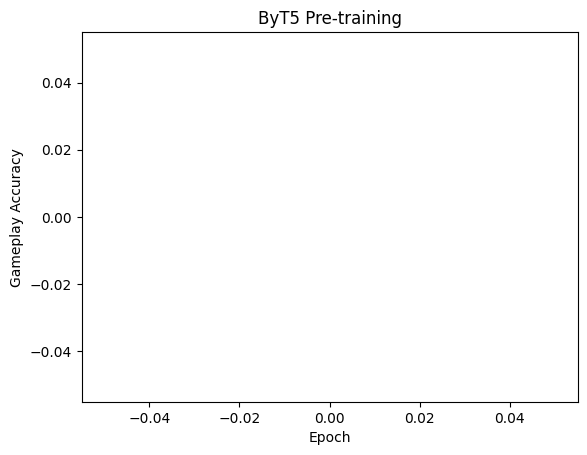

In [9]:
import numpy as np
import torch
from transformers import (
    ByT5Tokenizer,
    T5Config,
    T5ForSequenceClassification,
    TrainingArguments,
    Trainer,
    EvalPrediction
)
from datasets import Dataset
from sklearn.metrics import f1_score, accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm

# Tokenizer and constants for ByT5
BYT5_MASK_TOKEN = "<extra_id_0>"
BYT5_SEP_TOKEN = "<sep>"

def simulate_game(word, correct_rate=0.4, max_wrong_guesses=6):
    word_idxs = {}
    all_letters = [chr(i) for i in range(ord('a'), ord('z') + 1)]
    for i, c in enumerate(word):
        word_idxs.setdefault(c, []).append(i)
    guesses = {}
    encoded_word = "*" * len(word)
    num_guesses = 0
    states, outputs = [], []
    while encoded_word != word and num_guesses < max_wrong_guesses:
        # Build soft‐label distribution over next letter
        output = np.zeros(26)
        for ch, idxs in word_idxs.items():
            if ch not in guesses:
                output[ord(ch) - ord('a')] = len(idxs)
        out_sum = output.sum()
        if out_sum > 0:
            output = output / out_sum
        outputs.append(output)

        # Encode state: guessed letters + masked word
        state = ''.join(guesses.keys()) + BYT5_SEP_TOKEN + encoded_word.replace('*', BYT5_MASK_TOKEN)
        states.append(state)

        # Decide guess (correct vs random)
        if np.random.rand() < correct_rate:
            guess = np.random.choice([c for c in word_idxs if c not in guesses])
        else:
            guess = np.random.choice([c for c in all_letters if c not in guesses])

        # Apply guess
        if guess in word_idxs:
            for i in word_idxs[guess]:
                encoded_word = encoded_word[:i] + guess + encoded_word[i+1:]
        else:
            num_guesses += 1
        guesses[guess] = True

    return states, np.array(outputs), int(encoded_word == word)

def encode_game_states(dictionary):
    all_states, all_outputs = [], []
    total_solved = 0
    for w in dictionary:
        states, outputs, solved = simulate_game(w)
        all_states.extend(states)
        all_outputs.extend(outputs)
        total_solved += solved
    return all_states, np.array(all_outputs), total_solved / len(dictionary)

def metrics(preds, labels):
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(labels, axis=1)
    return {
        "f1": f1_score(y_true, y_pred, average="macro"),
        "accuracy": accuracy_score(y_true, y_pred)
    }

def compute_metrics(p: EvalPrediction):
    logits = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    return metrics(logits, p.label_ids)

class ByT5HangmanPlayer:
    """
    Hangman Player using Google ByT5-small for sequence classification
    """
    def __init__(self, saved_model_path=None):
        self.tokenizer = ByT5Tokenizer.from_pretrained("google/byt5-small")
        self.config = T5Config.from_pretrained("google/byt5-small")
        self.config.num_labels = 26
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        saved_model_path="byt5-checkpoint-epoch2"
        if saved_model_path:
            self.model = T5ForSequenceClassification.from_pretrained(
                saved_model_path, config=self.config
            ).to(self.device)
        else:
            self.model = T5ForSequenceClassification(self.config).to(self.device)
            # self.model = T5ForSequenceClassification.from_pretrained(
            #      config=self.config
            # ).to(self.device)

    def train(self):
        self.model.train()

    def eval(self):
        self.model.eval()

    def set_training(self, lr, weight_decay, batch_size=128, training_mode="pre-training"):
        if training_mode != "pre-training":
            raise ValueError("Only 'pre-training' mode is supported in this runner.")
        self.training_args = TrainingArguments(
            output_dir="./byt5-pretrained-hangman-log",
            overwrite_output_dir=True,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=256,
            logging_strategy="epoch",
            num_train_epochs=1,
            weight_decay=weight_decay,
            fp16=True,                     # mixed precision
            dataloader_num_workers=8 ,
            prediction_loss_only=True    

            # parallel data loading            
        )

    def simulate_hangman_transformers(self, word, max_wrong_guesses=6, verbose=0):
        # (Unmodified from earlier; used only for self-play evaluation)
        # ...
        pass  # omitted for brevity

    def test_accuracy(self, words):
        self.eval()
        correct = 0
        for w in words:
            if self.simulate_hangman_transformers(w):
                correct += 1
        return correct / len(words)

if __name__ == "__main__":
    # ----------------------------
    # 1. Prepare word lists
    # ----------------------------
    # train_words = ["apple", "banana", "grape", "peach", "mango"]
    # val_words   = ["melon",  "berry",  "lemon", "plum",  "kiwi"]

    # ----------------------------
    # 2. Init model & tokenizer
    # ----------------------------
    player = ByT5HangmanPlayer()
    player.set_training(lr=1e-5, weight_decay=1e-4, batch_size=256)

    # ----------------------------
    # 3. Build validation Dataset
    # ----------------------------
    val_states, val_labels, _ = encode_game_states(val_words)
    val_ds = Dataset.from_dict({"text": val_states, "label": val_labels})
    val_ds = val_ds.map(
        lambda ex: player.tokenizer(
            ex["text"],
            padding="max_length",
            truncation=True,
            max_length=64
        ),
        batched=True
    )
    # Fix: rename + set_format so Trainer sees labels
    val_ds = val_ds.rename_column("label", "labels")
    val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # ----------------------------
    # 4. Trainer setup
    # ----------------------------
    trainer = Trainer(
        model=player.model,
        args=player.training_args,
        tokenizer=player.tokenizer,
        compute_metrics=compute_metrics,
        train_dataset=None,      # injected each epoch
        eval_dataset=val_ds,
    )

    # ----------------------------
    # 5. Pre-training loop
    # ----------------------------
    val_metrics = []
    num_epochs = 3
    test_states, test_labels, _ = encode_game_states(val_words)
    test_ds = Dataset.from_dict({"text": test_states, "label": test_labels})
    test_ds = test_ds.map(lambda ex: player.tokenizer(ex['text'], padding="max_length", truncation=True, max_length=64), batched=True)
    test_ds = test_ds.rename_column("label", "labels")
    test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    metrics = trainer.evaluate(eval_dataset=test_ds)

    print("\n===== Test Set Evaluation =====")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

#     for epoch in range(num_epochs):
#         print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")
#         player.train()

#         # Build train Dataset
#         train_states, train_labels, _ = encode_game_states(train_words)
#         # print("\n==== Training Input/Output Examples ====\n")
#         # for state, label in zip(train_states[:100], train_labels[:100]):
#         #     top_indices = np.argsort(label)[::-1][:5]
#         #     top_chars = [(chr(i + ord('a')), round(label[i], 3)) for i in top_indices]
#         #     label_str = ", ".join(f"{ch}:{score}" for ch, score in top_chars)
#         #     print(f"Input state: {state}")
#         #     print(f"Top target letters: {label_str}\n")
#         # # print("========================================\n")
#         train_ds = Dataset.from_dict({"text": train_states, "label": train_labels})
#         train_ds = train_ds.map(
#             lambda ex: player.tokenizer(
#                 ex["text"],
#                 padding="max_length",
#                 truncation=True,
#                 max_length=64
#             ),
#             batched=True
#         )
#         train_ds = train_ds.rename_column("label", "labels")
#         train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

#         # Train
#         trainer.train_dataset = train_ds
#         trainer.train()
        
#         checkpoint_dir = f"./byt5-checkpoint-epoch{epoch+1}"
#         player.model.save_pretrained(checkpoint_dir)
#         player.tokenizer.save_pretrained(checkpoint_dir) 
        
#         # Evaluate self‐play accuracy
#         acc = player.test_accuracy(val_words)
#         val_metrics.append(acc)
#         print(f"Gameplay accuracy after epoch {epoch+1}: {acc:.4f}")

        # Save checkpoint
        # player.model.save_pretrained(f"./byt5-checkpoint-epoch{epoch+1}")

    # ----------------------------
    # 6. Plot & save accuracy curve
    # ----------------------------
    plt.plot(range(1, len(val_metrics)+1), val_metrics)
    plt.xlabel("Epoch")
    plt.ylabel("Gameplay Accuracy")
    plt.title("ByT5 Pre-training")
    plt.savefig("byt5_val_accuracy.png")
    print("Training complete. Validation curve saved to byt5_val_accuracy.png")


In [7]:
#Inference code , 

import numpy as np
import torch
from transformers import (
    ByT5Tokenizer,
    T5Config,
    T5ForSequenceClassification,
)
from datasets import Dataset
from tqdm import tqdm

# Tokenizer and constants for ByT5
BYT5_MASK_TOKEN = "<extra_id_0>"
BYT5_SEP_TOKEN = "<sep>"

def simulate_game(word, correct_rate=0.4, max_wrong_guesses=6):
    word_idxs = {}
    all_letters = [chr(i) for i in range(ord('a'), ord('z') + 1)]
    for i, c in enumerate(word):
        word_idxs.setdefault(c, []).append(i)
    guesses = {}
    encoded_word = "*" * len(word)
    num_guesses = 0
    states, outputs = [], []
    while encoded_word != word and num_guesses < max_wrong_guesses:
        output = np.zeros(26)
        for ch, idxs in word_idxs.items():
            if ch not in guesses:
                output[ord(ch) - ord('a')] = len(idxs)
        out_sum = output.sum()
        if out_sum > 0:
            output = output / out_sum
        outputs.append(output)
        state = ''.join(guesses.keys()) + BYT5_SEP_TOKEN + encoded_word.replace('*', BYT5_MASK_TOKEN)
        states.append(state)
        if np.random.rand() < correct_rate:
            guess = np.random.choice([c for c in word_idxs if c not in guesses])
        else:
            guess = np.random.choice([c for c in all_letters if c not in guesses])
        if guess in word_idxs:
            for i in word_idxs[guess]:
                encoded_word = encoded_word[:i] + guess + encoded_word[i+1:]
        else:
            num_guesses += 1
        guesses[guess] = True
    return states, np.array(outputs), int(encoded_word == word)

class ByT5HangmanPlayer:
    def __init__(self, saved_model_path=None):
        self.tokenizer = ByT5Tokenizer.from_pretrained("google/byt5-small")
        self.config = T5Config.from_pretrained("google/byt5-small")
        self.config.num_labels = 26
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # if saved_model_path:
        #     self.model = T5ForSequenceClassification.from_pretrained(saved_model_path, config=self.config).to(self.device)
        # else:
        self.model = T5ForSequenceClassification.from_pretrained("byt5-checkpoint-epoch4b", config=self.config).to(self.device)

    def eval(self):
        self.model.eval()

    def simulate_hangman_transformers(self, word, max_wrong_guesses=6, verbose=0):
        word_idxs = {}
        all_letters = [chr(i) for i in range(ord('a'), ord('z') + 1)]
        for i, c in enumerate(word):
            word_idxs.setdefault(c, []).append(i)
        guesses = {}
        encoded_word = "*" * len(word)
        num_wrong = 0
        self.eval()
        while encoded_word != word and num_wrong < max_wrong_guesses:
            state = ''.join(guesses.keys()) + BYT5_SEP_TOKEN + encoded_word.replace('*', BYT5_MASK_TOKEN)
            enc = self.tokenizer(state, padding="max_length", truncation=True, max_length=64, return_tensors="pt").to(self.device)
            with torch.no_grad():
                logits = self.model(**enc).logits
            arr = logits.cpu().numpy()[0]
            guess_idx = np.argmax(arr)
            guess = all_letters[guess_idx]
            while guess in guesses:
                arr[guess_idx] = -np.inf
                guess_idx = np.argmax(arr)
                guess = all_letters[guess_idx]
            if guess in word_idxs:
                for i in word_idxs[guess]:
                    encoded_word = encoded_word[:i] + guess + encoded_word[i+1:]
            else:
                num_wrong += 1
            guesses[guess] = True
        return int(encoded_word == word)

    def test_accuracy(self, words):
        correct = 0
        for w in tqdm(words, desc="Evaluating"):
            correct += self.simulate_hangman_transformers(w)
        return correct / len(words)

if __name__ == "__main__":
    import argparse
    import sys

    parser = argparse.ArgumentParser()
    parser.add_argument("--model_path", type=str, default=None, help="Path to pretrained ByT5 model")

    # Fix for Jupyter/IPython kernel args
    args = parser.parse_args(args=[] if sys.argv[0].endswith("ipykernel_launcher.py") else None)

    # Sample validation words (replace with your actual list)
    # val_words = ["melon", "berry", "lemon", "plum", "kiwi"]

    player = ByT5HangmanPlayer(saved_model_path=args.model_path)
    acc = player.test_accuracy(val_words)
    print(f"\nGameplay validation accuracy: {acc:.4f}")



Evaluating: 100%|██████████| 11365/11365 [31:14<00:00,  6.06it/s]


Gameplay validation accuracy: 0.3504


In [ ]:
import numpy as np
import torch
from transformers import (
    ByT5Tokenizer,
    T5Config,
    T5ForSequenceClassification,
)
from tqdm import tqdm

BYT5_MASK_TOKEN = "<extra_id_0>"
BYT5_SEP_TOKEN = "<sep>"

class ByT5HangmanPlayer:
    def __init__(self, saved_model_path=None):
        self.tokenizer = ByT5Tokenizer.from_pretrained("google/byt5-small")
        self.config = T5Config.from_pretrained("google/byt5-small")
        self.config.num_labels = 26
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # if saved_model_path:
        #     self.model = T5ForSequenceClassification.from_pretrained(saved_model_path, config=self.config).to(self.device)
        # else:
        #     self.model = T5ForSequenceClassification.from_pretrained("google/byt5-small", config=self.config).to(self.device)
        self.model = T5ForSequenceClassification.from_pretrained("byt5-checkpoint-epoch2", config=self.config).to(self.device)

    def eval(self):
        self.model.eval()

    def simulate_hangman_transformers(self, word, max_wrong_guesses=6, verbose=1):
        word_idxs = {}
        all_letters = [chr(i) for i in range(ord('a'), ord('z') + 1)]
        for i, c in enumerate(word):
            word_idxs.setdefault(c, []).append(i)

        guesses = {}
        encoded_word = "*" * len(word)
        num_wrong = 0
        self.eval()

        if verbose:
            print(f"\n[WORD]: {word}")

        while encoded_word != word and num_wrong < max_wrong_guesses:
            state = ''.join(guesses.keys()) + BYT5_SEP_TOKEN + encoded_word.replace('*', BYT5_MASK_TOKEN)
            enc = self.tokenizer(state, padding="max_length", truncation=True, max_length=64, return_tensors="pt").to(self.device)

            with torch.no_grad():
                logits = self.model(**enc).logits

            arr = logits.cpu().numpy()[0]
            guess_idx = np.argmax(arr)
            guess = all_letters[guess_idx]

            while guess in guesses:
                arr[guess_idx] = -np.inf
                guess_idx = np.argmax(arr)
                guess = all_letters[guess_idx]

            if guess in word_idxs:
                for i in word_idxs[guess]:
                    encoded_word = encoded_word[:i] + guess + encoded_word[i+1:]
            else:
                num_wrong += 1

            guesses[guess] = True

            if verbose:
                print(f"  Guess: {guess.upper():<2} → {encoded_word}  (Wrong guesses: {num_wrong})")

        result = encoded_word == word
        if verbose:
            print(f"Result: {'✅ CORRECT' if result else '❌ FAILED'} | Final: {encoded_word}\n")
        return result

    def test_accuracy(self, words, verbose=1):
        correct = 0
        for w in words:
            correct += self.simulate_hangman_transformers(w, verbose=verbose)
        return correct / len(words)

if __name__ == "__main__":
    import argparse
    import sys

    parser = argparse.ArgumentParser()
    parser.add_argument("--model_path", type=str, default=None, help="Path to pretrained ByT5 model")
    args = parser.parse_args(args=[] if sys.argv[0].endswith("ipykernel_launcher.py") else None)

    # Sample validation words
    # val_words = ["melon", "berry", "lemon", "plum", "kiwi"]

    # Initialize model
    player = ByT5HangmanPlayer(saved_model_path=args.model_path)

    # Run validation with detailed logs
    acc = player.test_accuracy(val_words, verbose=1)
    print(f"\n📊 Final Gameplay Validation Accuracy: {acc:.4f}")